### Import the packages required for the analysis

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

#Pandas options

pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', 4)

*Load two copies of the data file to clean, one to modify and one for storage purposes*

In [ ]:
data = pd.read_csv('accepted_2007_to_2017.csv', header=[0], encoding = 'utf-8')
data_store = pd.read_csv('accepted_2007_to_2017.csv', header=[0], encoding = 'utf-8')

*Check basic database information*

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646801 entries, 0 to 1646800
Columns: 150 entries, id to settlement_term
dtypes: float64(113), object(37)
memory usage: 1.8+ GB


*Pick 5 randomly selected rows (one corresponds to each loan) to get an idea of the dataset's raw data columns*

In [5]:
data.sample(5)

,id,member_id,...,settlement_percentage,settlement_term
674211,39660096,NaN,...,NaN,NaN
1442453,94028705,NaN,...,NaN,NaN
241329,977528,NaN,...,NaN,NaN
1531967,73855072,NaN,...,NaN,NaN
619963,43472156,NaN,...,NaN,NaN


*We will be predicting "loan status" so check counts for it. This helps as well if not all categories want to be kept and we need to understand which ones have more data points*

In [6]:
data['loan_status'].value_counts(dropna=False)

Current                                                788950
Fully Paid                                             646902
Charged Off                                            168084
Late (31-120 days)                                      23763
In Grace Period                                         10474
Late (16-30 days)                                        5786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    70
NaN                                                        23
Name: loan_status, dtype: int64

*Current loans have high count but cannot be used (there is not much to trivially predict), so will use 'Fully Paid' and 'Charged Off' as they have more data points*

In [7]:
data = data.loc[data['loan_status'].isin(['Fully Paid', 'Charged Off'])]

*We now check the number of loans remained in this dataset*

In [8]:
data.shape

(814986, 150)

*There are 814986 loans remaining. Now check their state breakdown for class imbabalance as well...*

In [9]:
data['loan_status'].value_counts(dropna=False)

Fully Paid     646902
Charged Off    168084
Name: loan_status, dtype: int64

*Now check as percentage*

In [ ]:
data['loan_status'].value_counts(normalize = True, dropna=False)

*So see that about 21% of loans are charged off and 79% fully paid... this is quite a class imbalance that we will want to account for*

*We now want to reduce the feature space so we look at missing data for the features and rank them according to this*

In [12]:
missing_fractions = data.isnull().mean().sort_values(ascending=False)

*View the 10 features missing the most data*

In [13]:
missing_fractions.head(10)

member_id                                     1.000000
next_pymnt_d                                  1.000000
orig_projected_additional_accrued_interest    0.999876
sec_app_mths_since_last_major_derog           0.999628
hardship_length                               0.999275
hardship_type                                 0.999275
hardship_reason                               0.999275
hardship_status                               0.999275
deferral_term                                 0.999275
hardship_amount                               0.999275
dtype: float64

*We now visualise this statistic as a histogram plot*

Text(0,0.5,'Feature count')

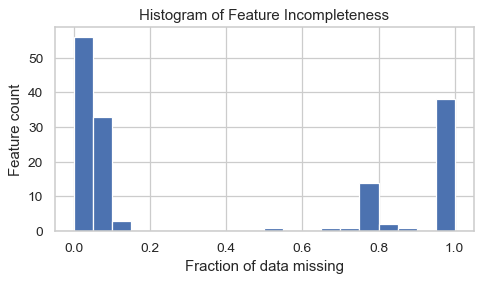

In [14]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

*From the above histogram, we see there's a large gap between features missing "some" data (<20%) and those missing "lots" of data (>40%). Because it's difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in an alphabetical list below.*

In [15]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

*Now count how many features will be dropped*

In [16]:
len(drop_list)

58

*Drop the features*

In [17]:
data.drop(labels=drop_list, axis=1, inplace=True)

*Check the shape of the remaining dataset*

In [18]:
data.shape

(814986, 92)

*We now keep only the features known before giving out the loan. Note: this is a more restrictive criteria as this differs from Kaggle analysis for investors including data such as interest rate! Let's print all the remaining features in alphabetical order.*

In [19]:
print(sorted(data.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

*For each of these features, we check the description in the Data Dictionary and only keep the features that are available before giving the loan. These include features in the loan application, but not any features added by LendingClub when the loan listing was accepted, such as the loan grade and interest rate!*

*I'm using my best available knowledge to determine which loan features are known to the loan provider. When in doubt, I apply a conservative approach to insure the validity of the analysis and drop the feature. Features relevant to the location are also dropped as a meaningful way to encode the location should be the subject of further work.*

In [20]:
keep_list = ['annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length',
             'fico_range_high', 'fico_range_low', 'home_ownership', 'installment', 'issue_d', 'loan_amnt',
             'loan_status', 'mort_acc', 'open_acc', 'pub_rec',
             'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'term', 'title', 'total_acc',
             'verification_status']

#commented list:
# -The self-reported annual income provided by the borrower during registration
# -Indicates whether the loan is an individual application or a joint application with two co-borrowers
# -A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
# -The month the borrower's earliest reported credit line was opened
# -Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
# -The job title supplied by the Borrower when applying for the loan.*
# Note: FICO scores seem to be based on information available before the loan so keep it. We could just calculate
#it.
# -The upper boundary range the borrower’s FICO at loan origination belongs to.
# -The lower boundary range the borrower’s FICO at loan origination belongs to.
# Note: -Grade was dropped but could be reintegrated if it could be calculated as by the Loan Club
# -The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
# -IDs are unique so dropped and anyway belong to the Loan Club
# -Again the initial listing of the loan belongs to the LC so dropped
# -The monthly payment owed by the borrower if the loan originates. (should drop as indicative of IR)
# Note: the score should be recalculated after IR assignment for installment purposes, but should not be too diff
# -int_rate is not available prior to loan evaluation
# -The month which the loan was funded (not really indication of future if not by month seasonality maybe...)
# -The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
# -Current status of the loan (our label....)
# -Number of mortgage accounts.
# -The number of open credit lines in the borrower's credit file.
# -Number of derogatory public records
# -Number of public record bankruptcies
# -A category provided by the borrower for the loan request.
# -Note revol_bal was dropped as understood as being during the loan. ?? Total credit revolving balance
# -Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
# -Note: sub_grade. LC assigned loan subgrade. Again belongs to LC so removed for now.
# -The number of payments on the loan. Values are in months and can be either 36 or 60.
# -The loan title provided by the borrower
# -The total number of credit lines currently in the borrower's credit file
# -Indicates if income was verified by LC, not verified, or if the income source was verified. ?????
# -zip_code not relavant as location bound... so removed

*Look at the employment title feature. I need to think about how to handle this feature... It could be useful but it needs work*

In [ ]:
data['emp_title'].value_counts(dropna=False)

In [21]:
data['emp_title'].describe()

count      766415
unique     280473
top       Teacher
freq        11351
Name: emp_title, dtype: object

*Drop the feature for now...*

In [ ]:
data.drop(labels='emp_title', axis=1, inplace=True)

*Check the number of kept features and the features dropped*

In [22]:
print('number of features left', len(keep_list))
drop_list = [col for col in data.columns if col not in keep_list]
print('dropped features')
print(drop_list)
print('number of dropped features ', len(drop_list))

number of features left 23
dropped features
['id', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'pymnt_plan', 'zip_code', 'addr_state', 'delinq_2yrs', 'inq_last_6mths', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_

*Drop the features*

In [23]:
data.drop(labels=drop_list, axis=1, inplace=True)
data.shape

(814986, 23)

We'll inspect each feature individually, and do the following:

-Drop the feature if it is not useful for predicting the loan status.
-View summary statistics and visualize the data, plotting against the loan status.
-Modify the feature to make it useful for modeling, if necessary.

*We first define a function to plot the data as we will reuse this over multiple features for analysis.*

In [24]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(data.loc[data[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(data[col_name], order=sorted(data[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=data, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = data.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()


*Print the list of remaining features for future reference and to know which ones to analyse*

In [25]:
print(list(data.columns))

['loan_amnt', 'term', 'installment', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'application_type', 'mort_acc', 'pub_rec_bankruptcies']


*The description of the 'loan_amnt' feature is: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.*

In [26]:
data['loan_amnt'].describe()

count    814986.000000
mean      14315.458210
std        8499.799241
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

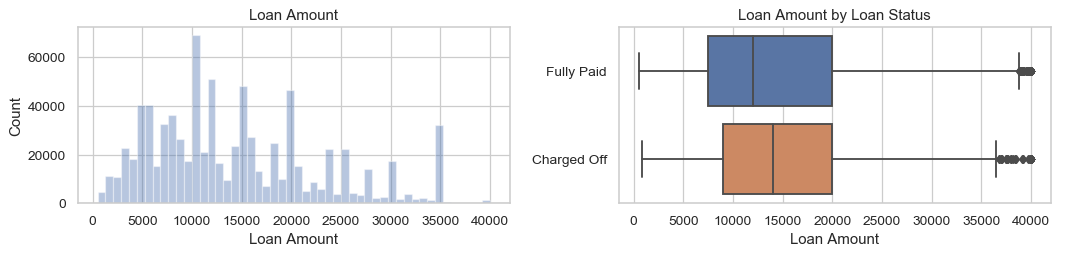

In [27]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

In [28]:
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)
#used to view all columns
data.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,15384.975964,8606.476332,900.0,9000.0,14000.0,20000.0,40000.0
Fully Paid,646902.0,14037.566316,8449.740674,500.0,7500.0,12000.0,20000.0,40000.0


*Again charged off loans have higher mean throughout apart from the maximum... (not really indicative the maximum). As can  be seen from the plot the maximum is an outlier, hence we think about removing it!*

*From the plots the paid loans seem to have slightly lower end and quantile ends to their loan amounts.
Indeed the average amount of charged off loans is higher as expected...*

In [29]:
data['term'].value_counts(dropna=False)

 36 months    618460
 60 months    196526
Name: term, dtype: int64

*Convert the labels to integers*

In [30]:
data['term'] = data['term'].apply(lambda s: np.int8(s.split()[0]))

In [31]:
data['term'].value_counts(normalize=True)

36    0.75886
60    0.24114
Name: term, dtype: float64

In [32]:
data.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.165710
60    0.333793
Name: loan_status, dtype: float64

*About 76% of the completed loans have three-year periods, and the rest have five-year periods. Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.*

*We now look at the 'installment' feature*

In [33]:
data['installment'].describe()

count    814986.000000
mean        436.749624
std         255.732093
min           4.930000
25%         251.400000
50%         377.040000
75%         576.290000
max        1714.540000
Name: installment, dtype: float64

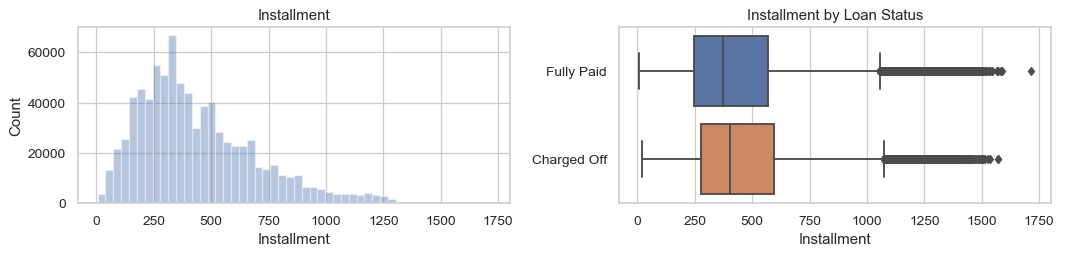

In [34]:
plot_var('installment', 'Installment', continuous=True)

In [35]:
data.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,459.973673,255.309267,21.62,276.14,402.39,595.87,1569.11
Fully Paid,646902.0,430.715339,255.496761,4.93,244.76,370.92,569.72,1714.54


*Again charged off loans have higher mean throughout apart from the maximum... (not really indicative the maximum). As can be seen from the plot the maximum is an outlier again.*

*Look at employment length now.*

In [36]:
data['emp_length'].value_counts(dropna=False).sort_index()

1 year        53411
10+ years    264873
2 years       73493
3 years       64999
4 years       48752
5 years       52149
6 years       40290
7 years       39407
8 years       38887
9 years       31900
< 1 year      64572
NaN           42253
Name: emp_length, dtype: int64

NOTE: there are 42,253 loans without data on the length of employment. We convert the employment length years to integers, as per the description in the documentation.

In [37]:
data['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
data['emp_length'].replace('< 1 year', '0 years', inplace=True)

def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
    
data['emp_length'] = data['emp_length'].apply(emp_length_to_int)

In [38]:
data['emp_length'].value_counts(dropna=False).sort_index()

 0.0      64572
 1.0      53411
 2.0      73493
 3.0      64999
 4.0      48752
 5.0      52149
 6.0      40290
 7.0      39407
 8.0      38887
 9.0      31900
 10.0    264873
NaN       42253
Name: emp_length, dtype: int64

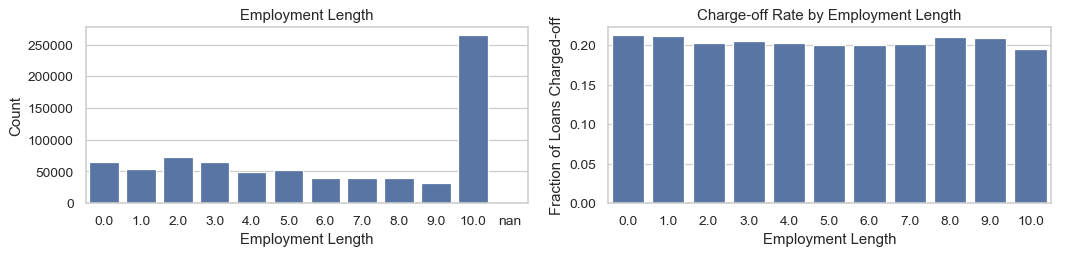

In [39]:
plot_var('emp_length', 'Employment Length', continuous=False)

*The charge off rate seems to stay constant with employment length, but there is a drop at 10 (and plus) years.*

*We now look at the home ownership feature.*

In [40]:
data['home_ownership'].describe()

count       814986
unique           6
top       MORTGAGE
freq        406866
Name: home_ownership, dtype: object

In [41]:
data['home_ownership'].value_counts(dropna=False)

MORTGAGE    406866
RENT        325071
OWN          82765
OTHER          144
ANY             94
NONE            46
Name: home_ownership, dtype: int64

*For the moment let's merge ANY, NONE and OTHER into OTHER, but we might just take them off as the total number is still lower than the top 3 categories.*




In [43]:
data['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

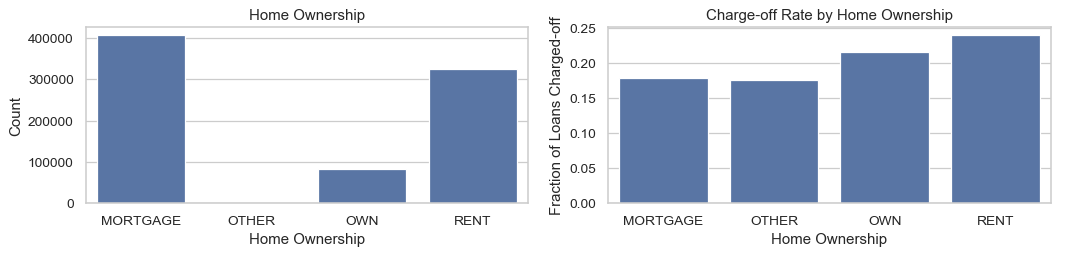

In [44]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

*Seems that owners and renters have higher default probability than mortgaged owners... This is slightly counterintuitive, but the feature seems to be a good indicator. Let's compare the actual rates!*

In [45]:
data.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.177808
OTHER       0.176056
OWN         0.215804
RENT        0.239422
Name: loan_status, dtype: float64

*Let's remove the OTHER category not to introduce relatively small, noisy categories. Let's keep only the OWN, RENT and MORTGAGE categories for now.*

In [46]:
data = data.loc[data['home_ownership'].isin(['MORTGAGE', 'OWN', 'RENT'])]
data['home_ownership'].value_counts(dropna=False)

MORTGAGE    406866
RENT        325071
OWN          82765
Name: home_ownership, dtype: int64

*We now look at the annual income feature*

In [47]:
data['annual_inc'].describe()

count    8.147020e+05
mean     7.523131e+04
std      6.524856e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.550000e+06
Name: annual_inc, dtype: float64

In [48]:
#plot_var('annual_inc', 'Annual Income', continuous=True)

*Annual income ranges from 0 to 9,550,000, with a median of 65,000. Because of the large range of incomes, we should take a log transform of the annual income variable. This is done also to avoid scaling effects which might make the middle range changes meaningless.*

In [49]:
data['log_annual_inc'] = data['annual_inc'].apply(lambda x: np.log10(x+1))
data.drop('annual_inc', axis=1, inplace=True)
data['log_annual_inc'].describe()

count    814702.000000
mean          4.810840
std           0.231895
min           0.000000
25%           4.653222
50%           4.812920
75%           4.954247
max           6.980003
Name: log_annual_inc, dtype: float64

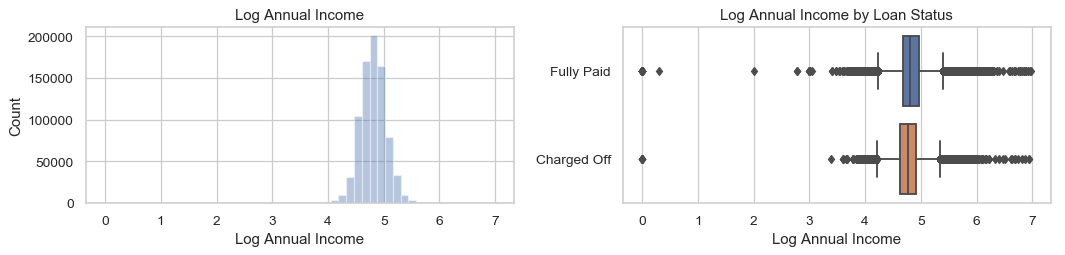

In [50]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

In [51]:
data.groupby('loan_status')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168034.0,4.777077,0.227024,0.0,4.632467,4.778158,4.915124,6.949393
Fully Paid,646668.0,4.819613,0.232343,0.0,4.672107,4.812920,4.963793,6.980003


*We shall check if we actually want to use the log scale as it impacts the mean... let's test like this for now.*

*Look at the 'verification_status' feature. We notice that there are three unique categories so we get the counts for each to see if they are all relevant.*

In [52]:
data['verification_status'].describe()

count              814702
unique                  3
top       Source Verified
freq               293843
Name: verification_status, dtype: object

In [53]:
data['verification_status'].value_counts(dropna=False).sort_index()
#indeed similar counts for all...

Not Verified       251075
Source Verified    293843
Verified           269784
Name: verification_status, dtype: int64

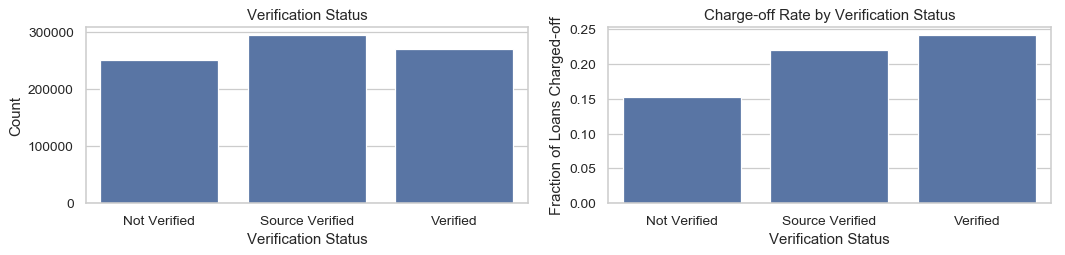

In [54]:
plot_var('verification_status', 'Verification Status', continuous=False)

*Again feature split indicative, but puzzling as 'Not Verified' loans have lowest 'Charged-Off' fraction. Let's see how it is classified in the models later on.*

*For the 'issue_d' feature we look at the Data Dictionary: "The month which the loan was funded." We keep this feature as we will use it to train with earlier datapoints and predict future ones.*

*We now look at the 'purpose' feature.*

In [55]:
data['purpose'].value_counts(dropna=False)

debt_consolidation    481532
credit_card           175044
home_improvement       50771
other                  43878
major_purchase         17455
small_business         10203
car                     8930
medical                 8767
moving                  5724
vacation                5115
house                   4091
wedding                 2271
renewable_energy         598
educational              323
Name: purpose, dtype: int64

In [56]:
data['purpose'].describe()

count                 814702
unique                    14
top       debt_consolidation
freq                  481532
Name: purpose, dtype: object

In [57]:
data.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

purpose
car                   0.148040
credit_card           0.178418
debt_consolidation    0.217400
educational           0.173375
home_improvement      0.181383
house                 0.214862
major_purchase        0.183329
medical               0.229497
moving                0.242837
other                 0.217034
renewable_energy      0.247492
small_business        0.302362
vacation              0.198827
wedding               0.121973
Name: loan_status, dtype: float64

NOTE: only 12% of 'wedding' loans were charged off while more than 30% of small business ones were

In [58]:
data['title'].describe()

count                 806784
unique                 60220
top       Debt consolidation
freq                  371808
Name: title, dtype: object

In [59]:
#view top 10 categories
data['title'].value_counts().head(10)

Debt consolidation         371808
Credit card refinancing    133307
Home improvement            39160
Other                       33259
Debt Consolidation          15054
Major purchase              12310
Medical expenses             6906
Business                     6665
Car financing                5663
Consolidation                5089
Name: title, dtype: int64

*There are 60,220 different titles in the dataset, and based on the top 10 titles, the purpose variable appears to already contain this information (maybe even in a better and more general format). So we drop the title variable. (we will check if this was a good idea later, but it should be)*

In [60]:
data.drop('title', axis=1, inplace=True)

*For the feature 'dti': Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."*

In [61]:
data['dti'].describe()

count    814666.000000
mean         17.868340
std           8.856609
min          -1.000000
25%          11.640000
50%          17.360000
75%          23.630000
max         999.000000
Name: dti, dtype: float64

*The min and max values do not seem to make much sense... check for outliers as they deviate from the percentile quite significantly. So plot a histogram below.*

Text(0.5,1,'Debt-to-income Ratio')

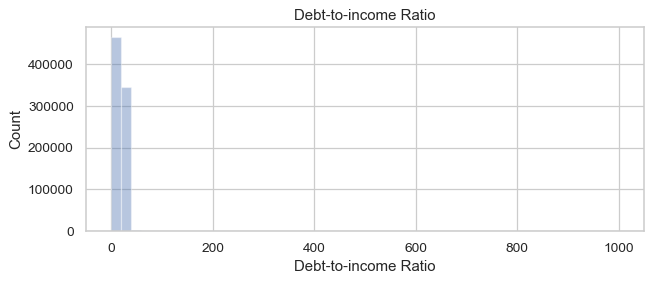

In [62]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(data.loc[data['dti'].notnull(), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

*Indeed the histogram is contaminated by outliers so we try to limit the range.*

Text(0.5,1,'Debt-to-income Ratio')

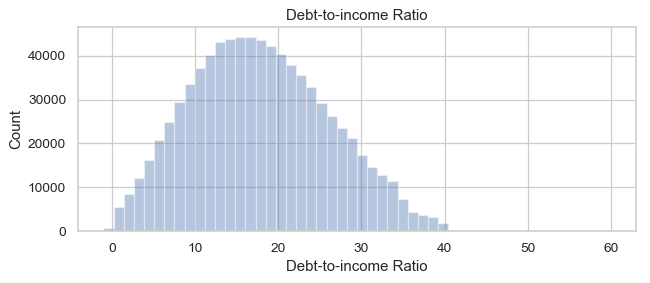

In [63]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(data.loc[data['dti'].notnull() & (data['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

*Extending the range it is still a good plot.*

Text(0.5,1,'Debt-to-income Ratio')

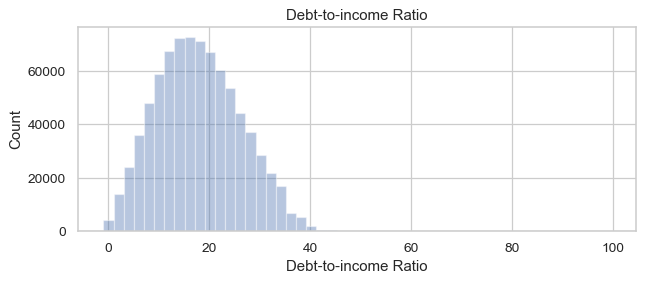

In [64]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(data.loc[data['dti'].notnull() & (data['dti']<100), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

*Extending the range further the plot gets worse though.*

Text(0.5,1,'Debt-to-income Ratio')

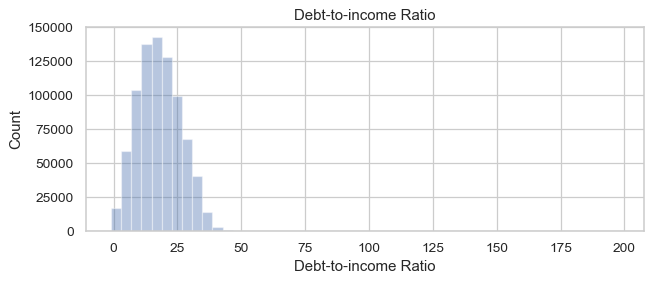

In [65]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(data.loc[data['dti'].notnull() & (data['dti']<200), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

*Now check for outliers at the high end of the original plot and check their counts.*

Text(0.5,1,'Debt-to-income Ratio')

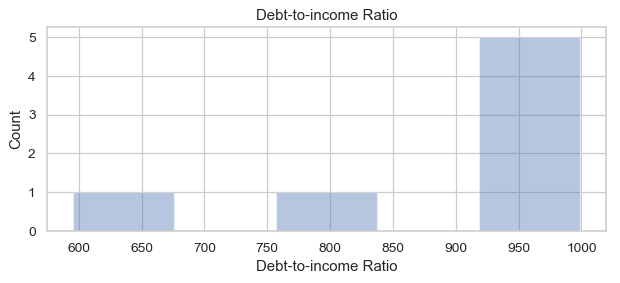

In [66]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(data.loc[data['dti'].notnull() & (data['dti']>500), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

*Check the number of outliers as we extend the high-end range.*

In [67]:
print((data['dti']>=500).sum())
print((data['dti']>=200).sum())
print((data['dti']>=100).sum())
print((data['dti']>=60).sum())
print((data['dti']>=45).sum())

7
22
62
179
756


*Check visually for outliers on the high end and check their counts.*

Text(0.5,1,'Debt-to-income Ratio')

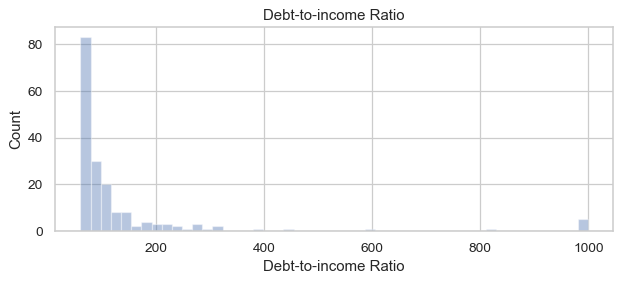

In [68]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(data.loc[data['dti'].notnull() & (data['dti']>60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

In [69]:
data.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168028.0,20.006067,8.991389,0.0,13.65,19.77,26.21,999.0
Fully Paid,646638.0,17.312855,8.736048,-1.0,11.22,16.77,22.90,999.0


*Charged off loans tend to have higher debt to income ratio... (this was to be expected)*

*The outliers on the high and low ends are likely not to have much effect and introduce noise so we remove them for now... We set cutoff at 200 and see (also higher than zero as this is makes sense).*

In [70]:
data.shape

(814702, 22)

In [71]:
data = data.loc[data['dti'].notnull() & (data['dti']<200) & (data['dti']>=0)]
data.shape
data.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168025.0,19.997684,8.636042,0.0,13.65,19.77,26.21,182.12
Fully Paid,646618.0,17.299287,8.204792,0.0,11.22,16.77,22.90,197.59


*Now look at feature 'earliest_cr_line': Data Dictionary: "The month the borrower's earliest reported credit line was opened."*

In [72]:
data['earliest_cr_line'].sample(5)

976840    Apr-1998
131729    Oct-2001
877446    Jul-2006
644288    Oct-1998
852319    Nov-1992
Name: earliest_cr_line, dtype: object

*Check for null values in the feature.*

In [73]:
data['earliest_cr_line'].isnull().any()

False

*Try keeping just the year for simplicity.*

In [74]:
data['earliest_cr_line'] = data['earliest_cr_line'].apply(lambda s: int(s[-4:]))

In [75]:
data['earliest_cr_line'].describe()

count    814643.000000
mean       1998.171311
std           7.385736
min        1944.000000
25%        1994.000000
50%        2000.000000
75%        2003.000000
max        2014.000000
Name: earliest_cr_line, dtype: float64

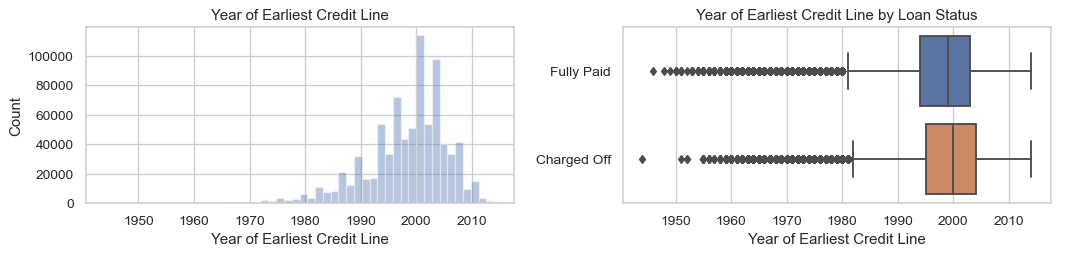

In [76]:
plot_var('earliest_cr_line', 'Year of Earliest Credit Line', continuous=True)

*Borrowers charged off tend to have more recent earliest credit date so shorter credit lines, indeed likely to be younger and more ecomically unstable still or less data was available to evaluate the borrower.*

*Now look at features 'fico_range_low' and 'fico_range_high'.*

Data Dictionary for fico_range_low: "The lower boundary range the borrower’s FICO at loan origination belongs to."

Data Dictionary for fico_range_high: "The upper boundary range the borrower’s FICO at loan origination belongs to."

In [77]:
data[['fico_range_low', 'fico_range_high']].describe()

,fico_range_low,fico_range_high
count,814643.000000,814643.000000
mean,695.600576,699.600689
std,31.351465,31.352005
min,625.000000,629.000000
25%,670.000000,674.000000
50%,690.000000,694.000000
75%,710.000000,714.000000
max,845.000000,850.000000


*We check for the Pearson correlation between these values.*

In [78]:
data[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


*They seem perfectly correlated so just merge them into one unweighted average feature.*

In [79]:
data['fico_score'] = 0.5*data['fico_range_low'] + 0.5*data['fico_range_high']

In [80]:
data.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

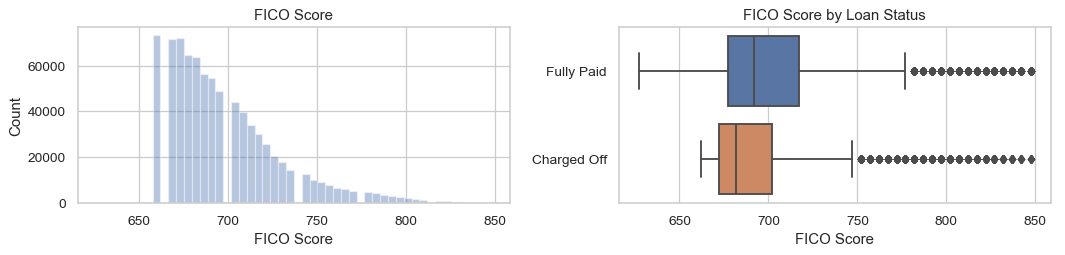

In [81]:
plot_var('fico_score', 'FICO Score', continuous=True)

*There is a noticeable difference between fully paid and charged off...*

In [82]:
data.groupby('loan_status')['fico_score'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168025.0,689.024687,25.081575,662.0,672.0,682.0,702.0,847.5
Fully Paid,646618.0,699.829109,32.416084,627.0,677.0,692.0,717.0,847.5


*Indeed the difference is reflected in the data with a 10 points lower FICO score on average for Charged Off loans.*

*Now look at the 'open_acc' feature, this corresponds to the Number of Open Credit Lines.*

In [83]:
data['open_acc'].describe()

count    814643.000000
mean         11.521527
std           5.325272
min           0.000000
25%           8.000000
50%          11.000000
75%          14.000000
max          90.000000
Name: open_acc, dtype: float64

Text(0.5,1,'Number of Open Credit Lines')

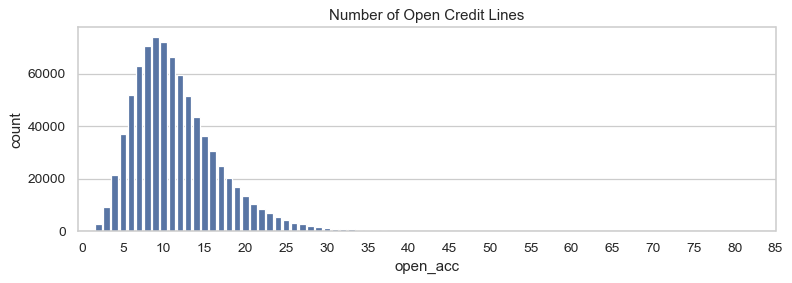

In [84]:
plt.figure(figsize=(10,3), dpi=90)
sns.countplot(data['open_acc'], order=sorted(data['open_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
plt.title('Number of Open Credit Lines')

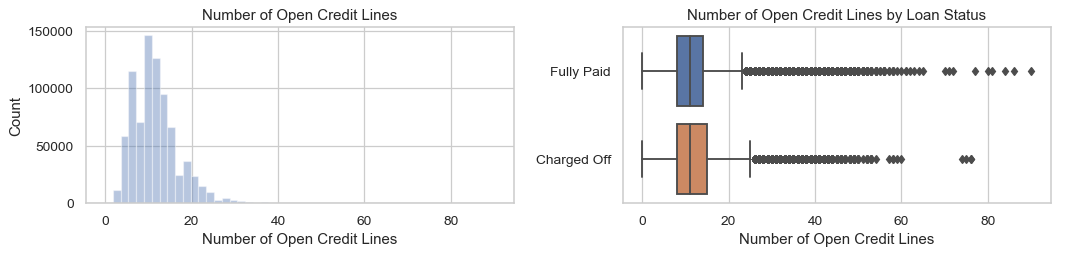

In [85]:
plot_var('open_acc', 'Number of Open Credit Lines', continuous=True)

*We check if there is a difference in the data... it did not seem so from the plots.*

In [86]:
data.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168025.0,11.883589,5.515779,0.0,8.0,11.0,15.0,76.0
Fully Paid,646618.0,11.427444,5.270577,0.0,8.0,11.0,14.0,90.0


*Now look at the feature 'pub_rec'. Data Dictionary: "Number of derogatory public records."*

In [87]:
data['pub_rec'].describe()

count    814643.000000
mean          0.205771
std           0.585000
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          86.000000
Name: pub_rec, dtype: float64

*The vast majority of people seem to have none, but a few have many... let's look at the counts*

In [88]:
data['pub_rec'].value_counts().sort_index()

0.0     681199
1.0     112456
2.0      14110
3.0       4106
4.0       1400
5.0        651
6.0        338
7.0        146
8.0         90
9.0         42
10.0        28
11.0        24
12.0        15
13.0        11
14.0         2
15.0         5
16.0         2
17.0         1
18.0         3
19.0         2
21.0         1
24.0         1
28.0         2
34.0         1
40.0         1
46.0         1
49.0         2
54.0         1
63.0         1
86.0         1
Name: pub_rec, dtype: int64

*How does this feature impact loan performance?*

In [89]:
data.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168025.0,0.232275,0.640911,0.0,0.0,0.0,0.0,86.0
Fully Paid,646618.0,0.198884,0.569372,0.0,0.0,0.0,0.0,63.0


*Indeed higher public record on average indicates a higher probability of being charged off.*

*We look at the 'revol_bal' feature (Revolving Balance) and log-scale it due to its large range of values.*

In [90]:
data['revol_bal'].describe()

count    8.146430e+05
mean     1.606881e+04
std      2.160543e+04
min      0.000000e+00
25%      6.014000e+03
50%      1.118500e+04
75%      1.972300e+04
max      2.568995e+06
Name: revol_bal, dtype: float64

In [91]:
data.groupby('loan_status')['revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168025.0,15510.604845,19187.580623,0.0,6131.0,11253.0,19432.0,1746716.0
Fully Paid,646618.0,16213.864589,22188.346681,0.0,5985.0,11167.0,19799.0,2568995.0


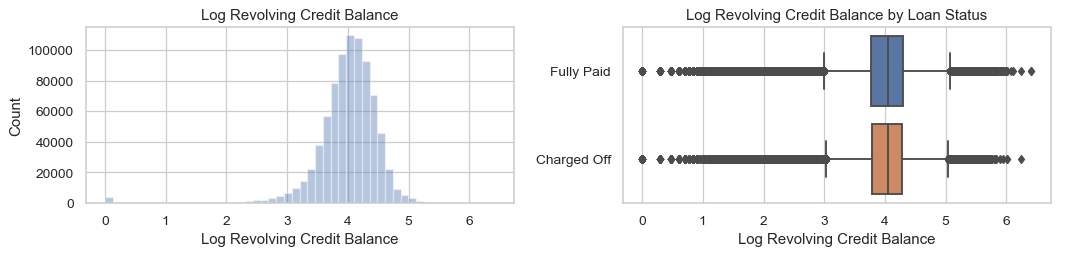

In [92]:
data['log_revol_bal'] = data['revol_bal'].apply(lambda x: np.log10(x+1))
plot_var('log_revol_bal', 'Log Revolving Credit Balance', continuous=True)

In [93]:
data.groupby('loan_status')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168025.0,3.997786,0.497402,0.0,3.787602,4.051307,4.288540,6.242223
Fully Paid,646618.0,3.994977,0.527178,0.0,3.777137,4.047975,4.296665,6.409763


*Plot the original feature.*

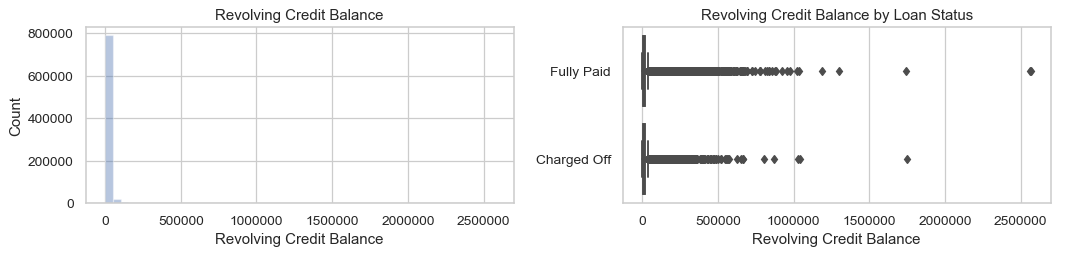

In [94]:
plot_var('revol_bal', 'Revolving Credit Balance', continuous=True)

*Now look at the < 200'000 range.*

Text(0.5,1,'Revolving Balance')

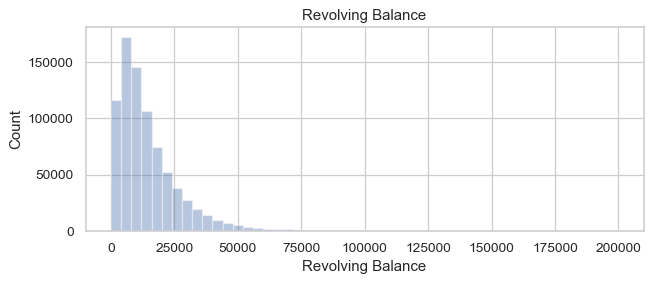

In [95]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(data.loc[data['revol_bal'].notnull() & (data['revol_bal']<200000), 'revol_bal'], kde=False)
plt.xlabel('Revolving Balance')
plt.ylabel('Count')
plt.title('Revolving Balance')

*Now look at the > 200'000 range.*

Text(0.5,1,'Revolving Balance')

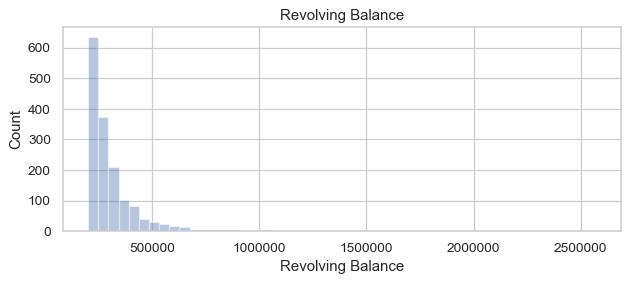

In [96]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(data.loc[data['revol_bal'].notnull() & (data['revol_bal']>200000), 'revol_bal'], kde=False)
plt.xlabel('Revolving Balance')
plt.ylabel('Count')
plt.title('Revolving Balance')

On a logarithmic scale the difference in mean in minimal, but on a linear scale the difference is a more meaningful 10% although the differences at the percentile steps are lower... question whether to neglect outliers or use log scale. Truth is that the decay looks exponential, but it might be of lower order so the logarithm is a too strong scaler. This need further thought and consideration, but for now use log for simplicity.

In [97]:
data.drop('revol_bal', axis=1, inplace=True)

In [98]:
print(list(data.columns))

['loan_amnt', 'term', 'installment', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'log_annual_inc', 'fico_score', 'log_revol_bal']


*Look at feature 'revol_util'. Data Dictionary: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."*

In [99]:
data['revol_util'].describe()

count    814155.000000
mean         53.031547
std          24.319688
min           0.000000
25%          35.000000
50%          53.700000
75%          71.900000
max         892.300000
Name: revol_util, dtype: float64

Text(0.5,1,'Revolving Utilization Rate')

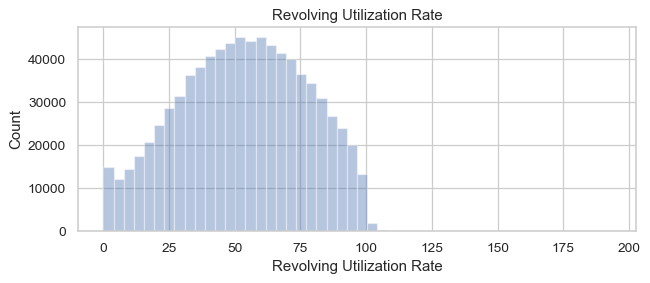

In [100]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(data.loc[data['revol_util'].notnull() & (data['revol_util']<200), 'revol_util'], kde=False)
plt.xlabel('Revolving Utilization Rate')
plt.ylabel('Count')
plt.title('Revolving Utilization Rate')

*Look at outlier counts...*

Text(0.5,1,'Revolving Utilization Rate')

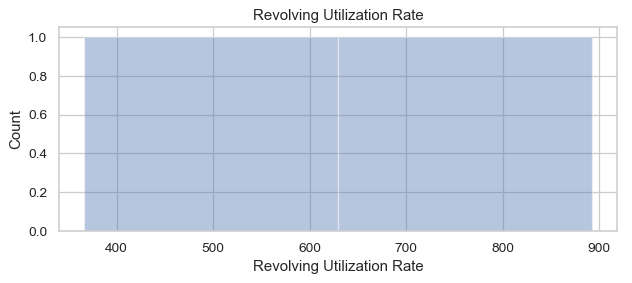

In [101]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(data.loc[data['revol_util'].notnull() & (data['revol_util']>200), 'revol_util'], kde=False)
plt.xlabel('Revolving Utilization Rate')
plt.ylabel('Count')
plt.title('Revolving Utilization Rate')

In [102]:
print((data['revol_util']>=100).sum())
print((data['revol_util']>=150).sum())
print((data['revol_util']>=200).sum())

2979
13
2


In [103]:
data.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,167915.0,56.475708,23.565683,0.0,39.5,57.5,74.7,366.6
Fully Paid,646240.0,52.136638,24.432489,0.0,33.9,52.7,71.0,892.3


Consistently higher revol_util on average for Charged Off.

The distribution looks good apart from a few outliers which for now we leave in as they have little of no influence likely...

Look at 'total_acc' feature. Data Dictionary: "The total number of credit lines currently in the borrower's credit file."

In [104]:
data['total_acc'].describe()

count    814643.000000
mean         25.422159
std          11.970824
min           2.000000
25%          17.000000
50%          24.000000
75%          32.000000
max         176.000000
Name: total_acc, dtype: float64

Text(0.5,1,'Total Number of Credit Lines')

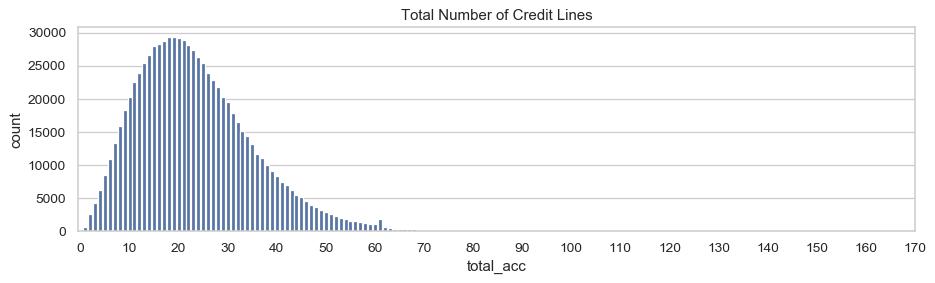

In [105]:
plt.figure(figsize=(12,3), dpi=90)
sns.countplot(data['total_acc'], order=sorted(data['total_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 176, 10), np.arange(0, 176, 10))
plt.title('Total Number of Credit Lines')

In [106]:
data.groupby('loan_status')['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168025.0,25.158982,12.121462,2.0,16.0,23.0,32.0,176.0
Fully Paid,646618.0,25.490546,11.930428,2.0,17.0,24.0,32.0,156.0


Slightly higher values for fully paid, but not major really...

*We now look at the feature 'application_type'.*

In [107]:
data['application_type'].value_counts()

Individual    810923
Joint App       3720
Name: application_type, dtype: int64

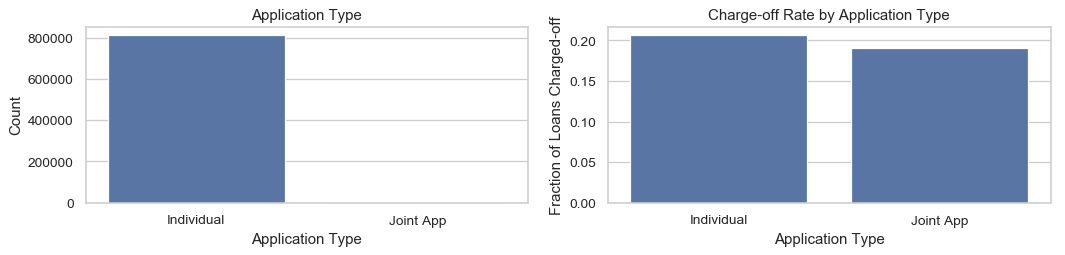

In [108]:
plot_var('application_type', 'Application Type', continuous=False)

In [109]:
data.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual    0.206327
Joint App     0.190860
Name: loan_status, dtype: float64

*Slightly higher rate for individual*

*Look at feature 'mort_acc'. Data Dictionary: "Number of mortgage accounts."*

In [111]:
data['mort_acc'].describe()

count    767464.000000
mean          1.758767
std           2.081806
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          51.000000
Name: mort_acc, dtype: float64

*Check how many variables we have and create dummy variables.*

*Puzzling number of max loan accounts... other values seem normal. As the average is not so high the 51 value should be an outlier. Check the distribution.*

Text(0.5,1,'Number of mortgage accounts')

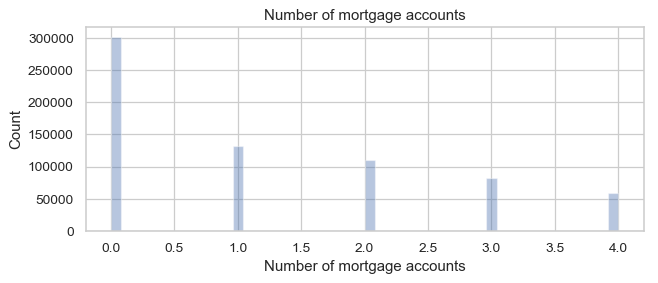

In [112]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(data.loc[data['mort_acc'].notnull() & (data['mort_acc']<5), 'mort_acc'], kde=False)
plt.xlabel('Number of mortgage accounts')
plt.ylabel('Count')
plt.title('Number of mortgage accounts')

*Compare by loan status.*

In [113]:
data.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,161158.0,1.447418,1.901889,0.0,0.0,1.0,2.0,29.0
Fully Paid,606306.0,1.841524,2.119391,0.0,0.0,1.0,3.0,51.0


In [114]:
print((data['mort_acc']>=5).sum())
print((data['mort_acc']>=10).sum())

83140
3721


*Seems like individuals with higher mort_acc were more likely to be Fully Paying... We do not modify this feature for now.*

In [115]:
print(list(data.columns))

['loan_amnt', 'term', 'installment', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'log_annual_inc', 'fico_score', 'log_revol_bal']


*Look at feature 'pub_rec_bankruptcies'. Data Dictionary: "Number of public record bankruptcies."*

In [116]:
data['pub_rec_bankruptcies'].describe()

count    813949.000000
mean          0.132033
std           0.375221
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: pub_rec_bankruptcies, dtype: float64

In [117]:
data['pub_rec_bankruptcies'].value_counts()

0.0     714324
1.0      93660
2.0       4671
3.0        926
4.0        234
5.0         85
6.0         28
7.0         14
8.0          5
12.0         1
9.0          1
Name: pub_rec_bankruptcies, dtype: int64

Text(0.5,1,'Number of public record bankruptcies')

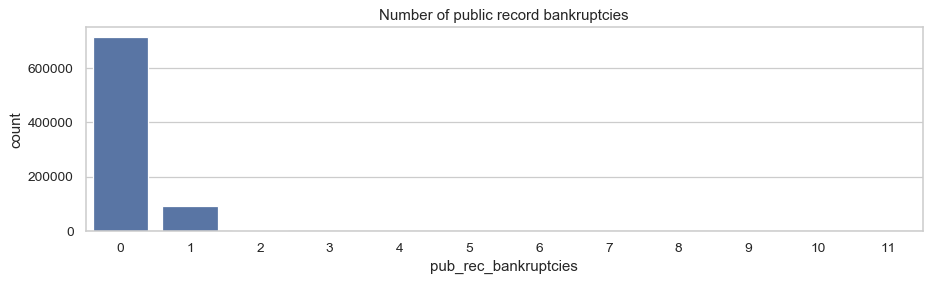

In [118]:
plt.figure(figsize=(12,3), dpi=90)
sns.countplot(data['pub_rec_bankruptcies'], order=sorted(data['pub_rec_bankruptcies'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 12, 1), np.arange(0, 12, 1))
plt.title('Number of public record bankruptcies')

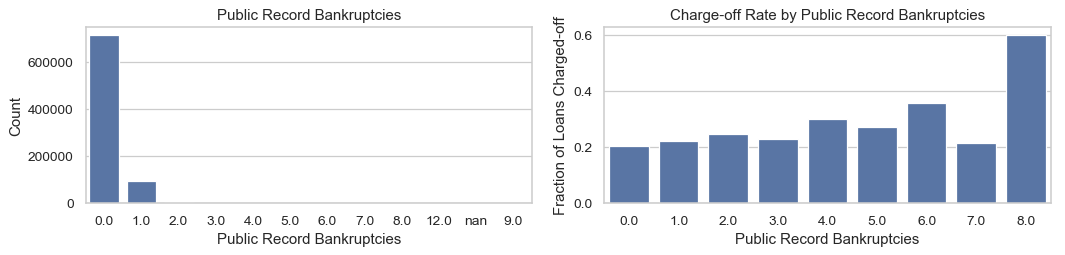

In [119]:
plot_var('pub_rec_bankruptcies', 'Public Record Bankruptcies', continuous=False)

The high end of public record bankruptcies has a higher Charged-Off fraction as expected...

Further Pre_Processing!

Convert loan status to a 1/0 Charged off indicator

In [120]:
data['charged_off'] = (data['loan_status'] == 'Charged Off').apply(np.uint8)
data.drop('loan_status', axis=1, inplace=True)

Check how many variables we have and create dummy variables

In [121]:
data.shape

(814643, 21)

Now convert categorical variables into dummy variables...
If any categorical variables have missing values, we'll need to create NaN dummy variables for those. So first check which variables have missing data (by fraction here):

In [122]:
missing_fractions = data.isnull().mean().sort_values(ascending=False)

In [123]:
print(missing_fractions[missing_fractions > 0]) # Print variables that are missing data

mort_acc                0.057914
emp_length              0.051801
pub_rec_bankruptcies    0.000852
revol_util              0.000599
dtype: float64


There are no categorical variables with missing values, and therefore we don't need any NaN dummy variables.

Create dummy variables for the categorical variables:

In [124]:
print(data.columns)

Index(['loan_amnt', 'term', 'installment', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'purpose', 'dti', 'earliest_cr_line',
       'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'log_annual_inc', 'fico_score',
       'log_revol_bal', 'charged_off'],
      dtype='object')


In [125]:
for i in ['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state',
                                       'initial_list_status', 'application_type']:
    print(i in data.columns)

False
True
True
True
False
False
True


*We first export the processed dataset without dummy variables in order to have both versions. (This will be the version used by the models as they create their own dummy variables directly)*

In [126]:
data.to_csv('accepted_2007_to_2017_all_V_0.csv', sep = ',')

*When creating the dummy columns we do not drop the first column. It would be more compact, but this is not straightforward to read in terms of correlations.*

In [127]:
data_dummies = pd.get_dummies(data, columns=['home_ownership', 'verification_status', 'purpose', 'application_type'],
                      drop_first=False)


In [128]:
data_dummies.shape

(814643, 39)

*Indeed from 16 to 39 columns.*

We will make our modeling problem more realistic by performing the train/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict whether future loans will charge-off. The variable 'issue_d' includes the month and year that the loan was funded.

In [129]:
data_dummies['issue_d'].sample(5)

90328     Aug-2014
71979     Oct-2014
613510    Apr-2015
57643     Oct-2014
778786    Apr-2017
Name: issue_d, dtype: object

Any missing values?

In [130]:
data_dummies['issue_d'].isnull().any()

False

No. Let's convert the issue dates to datetime objects:

In [131]:
data_dummies['issue_d'] = pd.to_datetime(data_dummies['issue_d'])

In [132]:
data_dummies['issue_d'].sample(5)

1598841   2016-02-01
138496    2014-06-01
1591605   2016-02-01
793591    2017-04-01
864747    2013-08-01
Name: issue_d, dtype: datetime64[ns]

The new datetime values are all on the first day of the month. Check the summary statistics of the issue dates:

In [133]:
data_dummies['issue_d'].describe()

count                  814643
unique                    124
top       2014-10-01 00:00:00
freq                    33699
first     2007-06-01 00:00:00
last      2017-09-01 00:00:00
Name: issue_d, dtype: object

There are only 124 unique issue dates over the 10-year period because we only have month/year information. In this particular dataset, the first loans were issued in June 2007, and the most recent loans were issued in September 2017. The busiest month was October 2014 with 33,699 loans funded in that month. What is the distribution of loans funded in each year?

Text(0.5,1,'Loans Funded per Year')

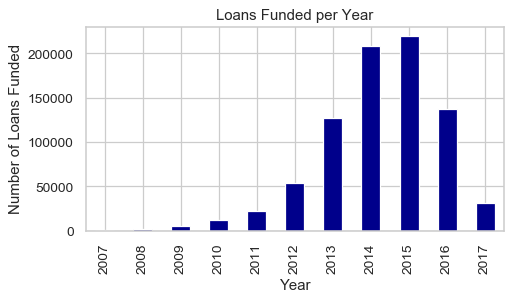

In [134]:
plt.figure(figsize=(6,3), dpi=90)
data_dummies['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

We'll form the test set for initial analysis purposes here from the most recent 10% of the loans.

*We first save the dataset with dummy variables.*

In [135]:
data_dummies.to_csv('accepted_2007_to_2017_dummies_all.csv', sep = ',')

In [136]:
data_train = data_dummies.loc[data_dummies['issue_d'] < data_dummies['issue_d'].quantile(0.9)]
data_test = data_dummies.loc[data_dummies['issue_d'] >= data_dummies['issue_d'].quantile(0.9)]

Check that we properly partitioned the loans:

In [137]:
print('Number of loans in the partition:   ', data_train.shape[0] + data_test.shape[0])
print('Number of loans in the full dataset:', data_dummies.shape[0])

Number of loans in the partition:    814643
Number of loans in the full dataset: 814643


Test size is:

In [138]:
data_test.shape[0] / data_dummies.shape[0]

0.10279963124951666

About 10.3%. The partition looks good.

In [139]:
data_train['issue_d'].describe()

count                  730898
unique                    109
top       2014-10-01 00:00:00
freq                    33699
first     2007-06-01 00:00:00
last      2016-06-01 00:00:00
Name: issue_d, dtype: object

In [140]:
data_test['issue_d'].describe()

count                   83745
unique                     15
top       2016-07-01 00:00:00
freq                    10825
first     2016-07-01 00:00:00
last      2017-09-01 00:00:00
Name: issue_d, dtype: object

The training set includes loans from June 2007 to June 2016. The test set includes loans from July 2016 to September 2017.

Now we need to delete the issue_d variable, because it was not available before the loan was funded (and should not be a meaningful feature intuitively).


In [ ]:
data_train.drop('issue_d', axis=1, inplace=True)
data_test.drop('issue_d', axis=1, inplace=True)

In [142]:
y_train = data_train['charged_off']
y_test = data_test['charged_off']

In [143]:
X_train = data_train.drop('charged_off', axis=1)
X_test = data_test.drop('charged_off', axis=1)

In [144]:
del data_train, data_test

On the training set, we compute the Pearson correlation,  F
 -statistic, and  p
  value of each predictor with the response variable charged_off.

In [145]:
linear_dep = pd.DataFrame()

*Look at pearson correlations.*

In [146]:
for col in X_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])

In [ ]:
from sklearn.feature_selection import f_classif
for col in X_train.columns:
    mask = X_train[col].notnull()
    (linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])

Sort the results by the absolute value of the Pearson correlation:

In [148]:
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)

In [149]:
#reset the index
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True)

Top 20 predictors most correlated with charged_off

In [150]:
linear_dep.head(20)

,variable,pearson_corr,F,p_value
0,term,0.188625,26964.111625,0.0
1,fico_score,-0.139941,NaN,NaN
2,dti,0.134047,NaN,NaN
3,verification_status_Not Verified,-0.090055,NaN,NaN
4,mort_acc,-0.076683,NaN,NaN
5,log_annual_inc,-0.074453,NaN,NaN
6,home_ownership_MORTGAGE,-0.067822,NaN,NaN
7,revol_util,0.066578,NaN,NaN
8,loan_amnt,0.063593,2967.761075,0.0
9,home_ownership_RENT,0.063569,NaN,NaN


The variables most linearly correlated with charged_off are the loan period (term), FICO score, debt-to-income ratio, number of mortgages, income, the loan grade, and the loan amount.

Now view the results for the 20 least correlated predictors:

In [151]:
linear_dep.tail(20)

,variable,pearson_corr,F,p_value
17,purpose_small_business,0.026295,NaN,NaN
18,pub_rec,0.025318,NaN,NaN
19,pub_rec_bankruptcies,0.020438,NaN,NaN
20,purpose_car,-0.015221,NaN,NaN
21,purpose_home_improvement,-0.014551,NaN,NaN
22,purpose_wedding,-0.012077,NaN,NaN
23,emp_length,-0.009576,NaN,NaN
24,home_ownership_OWN,0.009142,NaN,NaN
25,purpose_major_purchase,-0.008939,NaN,NaN
26,application_type_Joint App,0.008857,NaN,NaN


Note: 'purpose_small_business' is quite relevant feature (above 50% in ranking so should be good to use whole dataset...). It also looks like some purposes are irrelevant.